In [2]:
import jax.numpy as np
from jax import random, grad, vmap, jit, jacfwd, jacrev
from jax.example_libraries import optimizers
from jax.experimental.jet import jet
from jax.nn import relu
from jax.config import config
from jax import lax
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange

import scipy.io




# Define MLP
def MLP(layers, L=1.0, M=1, activation=relu):
  # Define input encoding function
    def input_encoding(t, x):
        w = 2.0 * np.pi / L
        k = np.arange(1, M + 1)
        out = np.hstack([t, 1,
                         np.cos(k * w * x), np.sin(k * w * x)])
        return out

    def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
    def apply(params, inputs):
        t = inputs[0]
        x = inputs[1]
        H = input_encoding(t, x)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs
    return init, apply


# Define modified MLP
def modified_MLP(layers, L=1.0, M=1, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  # Define input encoding function
  def input_encoding(t, x):
      w = 2 * np.pi / L
      k = np.arange(1, M + 1)
      out = np.hstack([t, 1,
                         np.cos(k * w * x), np.sin(k * w * x)])
      return out


  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2)

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params

      t = inputs[0]
      x = inputs[1]
      inputs = input_encoding(t, x)
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


class DataGenerator(data.Dataset):
    def __init__(self, t0, t1, n_t=10, n_x=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.t0 = t0
        self.t1 = t1
        self.n_t = n_t
        self.n_x = n_x
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        batch = self.__data_generation(subkey)
        return batch

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        subkeys = random.split(key, 2)
        t_r = random.uniform(subkeys[0], shape=(self.n_t,), minval=self.t0, maxval=self.t1).sort()
        x_r = random.uniform(subkeys[1], shape=(self.n_x,), minval=-1.0, maxval=1.0)
        batch = (t_r, x_r)
        return batch



# Define the model
class PINN:
    def __init__(self, key, arch, layers, M_x, state0, t0, t1, n_t, n_x, tol=1.0):

        # grid
        eps = 0.01 * t1
        self.t_r = np.linspace(t0, t1 + eps, n_t)
        self.x_r = np.linspace(-1.0, 1.0, n_x)

        # IC
        t_ic = np.zeros((x_star.shape[0], 1))
        x_ic = x_star.reshape(-1, 1)
        self.X_ic = np.hstack([t_ic, x_ic])
        self.Y_ic = state0

        # Weight matrix and causal parameter
        self.M = np.triu(np.ones((n_t, n_t)), k=1).T
        self.tol = tol

        if arch == 'MLP':
            d0 = 2 * M_x + 2
            layers = [d0] + layers
            self.init, self.apply = MLP(layers, L=2.0, M=M_x, activation=np.tanh)
            params = self.init(rng_key = key)

        if arch == 'modified_MLP':
            d0 = 2 * M_x + 2
            layers = [d0] + layers
            self.init, self.apply = modified_MLP(layers, L=2.0, M=M_x, activation=np.tanh)
            params = self.init(rng_key = key)


        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init,  self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)
        _, self.unravel = ravel_pytree(params)

        # Evaluate functions over a grid
        self.u_pred_fn = vmap(vmap(self.neural_net, (None, 0, None)), (None, None, 0))  # consistent with the dataset
        self.r_pred_fn = vmap(vmap(self.residual_net, (None, None, 0)), (None, 0, None))

        # Logger
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []

        self.itercount = itertools.count()


    def neural_net(self, params, t, x):
        z = np.stack([t, x])
        outputs = self.apply(params, z)
        return outputs[0]

    def residual_net(self, params, t, x):
        u = self.neural_net(params, t, x)
        u_t = grad(self.neural_net, argnums=1)(params, t, x)
        u_fn = lambda x: self.neural_net(params, t, x) # For using Taylor-mode AD
        _, (u_x, u_xx, u_xxx, u_xxxx) = jet(u_fn, (x, ), [[1.0, 0.0, 0.0, 0.0]]) #  Taylor-mode AD
        return u_t + 5 * u * u_x + 0.5 * u_xx + 0.005 * u_xxxx

    # Compute the temporal weights
    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params, batch, tol):
        t_r, x_r = batch
        L_0 = 1e3 * self.loss_ics(params)
        r_pred = self.r_pred_fn(params, t_r, x_r)
        L_t = np.mean(r_pred**2, axis=1)
        W = lax.stop_gradient(np.exp(- tol * (self.M @ L_t + L_0) ))
        return L_0, L_t, W

    # Initial condition loss
    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params):
        # Compute forward pass
        u_pred = vmap(self.neural_net, (None, 0, 0))(params, self.X_ic[:,0], self.X_ic[:,1])
        # Compute loss
        loss_ics = np.mean((self.Y_ic.flatten() - u_pred.flatten())**2)
        return loss_ics

    # Residual loss
    @partial(jit, static_argnums=(0,))
    def loss_res(self, params, batch):
        t_r, x_r = batch
        # Compute forward pass
        r_pred = self.r_pred_fn(params, t_r, x_r)
        # Compute loss
        loss_r = np.mean(r_pred**2)
        return loss_r

    # Total loss
    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch):
        L_0, L_t, W = self.residuals_and_weights(params, batch, self.tol)
        # Compute loss
        loss = np.mean(W * L_t + L_0)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        res_data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Get batch
            batch= next(res_data)
            self.current_count = next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state, batch)

            if it % 1000 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params, batch)
                loss_ics_value = self.loss_ics(params)
                loss_res_value = self.loss_res(params, batch)
                _, _, W_value = self.residuals_and_weights(params, batch, self.tol)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)

                pbar.set_postfix({'Loss': loss_value,
                                  'loss_ics' : loss_ics_value,
                                  'loss_res':  loss_res_value,
                                  'W_min'  : W_value.min()})

                if W_value.min() > 0.99:
                    break


# Load data
data = scipy.io.loadmat('ks_simple.mat')
# Test data
usol = data['usol']


# Hpyer-parameters
key = random.PRNGKey(1234)
M_t = 2
M_x = 5
t0 = 0.0
t1 = 0.1
n_t = 32
n_x = 64
tol_list = [1e-2, 1e-1, 1e0, 1e1, 1e2]
layers = [256, 256, 256, 1] # using Fourier embedding so it is not 1

# Initial state
state0 = usol[:, 0:1]
dt = 1 / 250
idx = int(t1 / dt)
t_star = data['t'][0][:idx]
x_star = data['x'][0]

# Create data set
dataset = DataGenerator(t0, t1, n_t, n_x)

arch = 'modified_MLP'
print('arch:', arch)

N = 10
u_pred_list = []
params_list = []
losses_list = []


# Time marching
for k in range(N):
    # Initialize model
    print('Final Time: {}'.format((k + 1) * t1))
    model = PINN(key, arch, layers, M_x, state0, t0, t1, n_t, n_x)

    # Train
    if k==0:
      for tol in tol_list:
          model.tol = tol
          print("tol:", model.tol)
          # Train
          model.train(dataset, nIter=200000)
    else:
      for tol in tol_list:
          model.tol = tol
          print("tol:", model.tol)
          # Train
          model.train(dataset, nIter=2)
    # Store
    params = model.get_params(model.opt_state)
    u_pred = model.u_pred_fn(params, t_star, x_star)
    u_pred_list.append(u_pred)
    flat_params, _  = ravel_pytree(params)
    params_list.append(flat_params)
    losses_list.append([model.loss_log, model.loss_ics_log, model.loss_res_log])


    np.save('u_pred_list.npy', u_pred_list)
    np.save('params_list.npy', params_list)
    np.save('losses_list.npy', losses_list)

    # error
    u_preds = np.hstack(u_pred_list)
    error = np.linalg.norm(u_preds - usol[:, :(k+1) * idx]) / np.linalg.norm(usol[:, :(k+1) * idx])
    print('Relative l2 error: {:.3e}'.format(error))

    params = model.get_params(model.opt_state)
    u0_pred = vmap(model.neural_net, (None, None, 0))(params, t1, x_star)
    state0 = u0_pred

Mounted at /content/drive
arch: modified_MLP
Final Time: 0.1
tol: 0.01


100%|██████████| 10/10 [01:17<00:00,  7.76s/it, Loss=305.27338, loss_ics=0.2890444, loss_res=9257.795, W_min=0.0]


tol: 0.1


100%|██████████| 10/10 [00:46<00:00,  4.63s/it, Loss=66.12766, loss_ics=0.015212934, loss_res=1934.5469, W_min=0.0]


tol: 1.0


100%|██████████| 10/10 [00:45<00:00,  4.56s/it, Loss=42.060944, loss_ics=0.0059838593, loss_res=1265.0883, W_min=0.0]


tol: 10.0


100%|██████████| 10/10 [00:51<00:00,  5.17s/it, Loss=30.413538, loss_ics=0.0022058527, loss_res=921.8421, W_min=0.0]


tol: 100.0


100%|██████████| 10/10 [00:46<00:00,  4.63s/it, Loss=14.985549, loss_ics=0.0018772257, loss_res=429.1317, W_min=0.0]


Relative l2 error: 5.355e-01
Final Time: 0.2
tol: 0.01


100%|██████████| 2/2 [00:37<00:00, 18.63s/it, Loss=308.7699, loss_ics=0.292202, loss_res=9837.886, W_min=0.0]


tol: 0.1


100%|██████████| 2/2 [00:10<00:00,  5.48s/it, Loss=125.85948, loss_ics=0.10518296, loss_res=1899.9575, W_min=0.0]


tol: 1.0


100%|██████████| 2/2 [00:09<00:00,  4.77s/it, Loss=62.63208, loss_ics=0.02884749, loss_res=1451.7014, W_min=0.0]


tol: 10.0


100%|██████████| 2/2 [00:10<00:00,  5.32s/it, Loss=37.794117, loss_ics=0.006930753, loss_res=1037.7513, W_min=0.0]


tol: 100.0


100%|██████████| 2/2 [00:09<00:00,  4.97s/it, Loss=42.253845, loss_ics=0.009376385, loss_res=1171.7065, W_min=0.0]


Relative l2 error: 8.206e-01
Final Time: 0.30000000000000004
tol: 0.01


100%|██████████| 2/2 [00:36<00:00, 18.03s/it, Loss=425.72568, loss_ics=0.42069286, loss_res=10801.83, W_min=0.0]


tol: 0.1


100%|██████████| 2/2 [00:11<00:00,  5.54s/it, Loss=201.9086, loss_ics=0.16908431, loss_res=5674.1865, W_min=0.0]


tol: 1.0


100%|██████████| 2/2 [00:10<00:00,  5.47s/it, Loss=77.15199, loss_ics=0.05316241, loss_res=1327.3245, W_min=0.0]


tol: 10.0


100%|██████████| 2/2 [00:09<00:00,  4.93s/it, Loss=48.959465, loss_ics=0.013536281, loss_res=1312.5005, W_min=0.0]


tol: 100.0


100%|██████████| 2/2 [00:09<00:00,  4.66s/it, Loss=51.36169, loss_ics=0.009688167, loss_res=1466.9285, W_min=0.0]


Relative l2 error: 1.025e+00
Final Time: 0.4
tol: 0.01


100%|██████████| 2/2 [00:35<00:00, 17.53s/it, Loss=555.7734, loss_ics=0.55415416, loss_res=13198.988, W_min=0.0]


tol: 0.1


100%|██████████| 2/2 [00:08<00:00,  4.26s/it, Loss=275.96582, loss_ics=0.24587348, loss_res=11226.402, W_min=0.0]


tol: 1.0


100%|██████████| 2/2 [00:09<00:00,  4.79s/it, Loss=106.56862, loss_ics=0.08156082, loss_res=1793.9458, W_min=0.0]


tol: 10.0


100%|██████████| 2/2 [00:11<00:00,  5.73s/it, Loss=55.86393, loss_ics=0.021664241, loss_res=1380.5382, W_min=0.0]


tol: 100.0


100%|██████████| 2/2 [00:09<00:00,  4.51s/it, Loss=65.84236, loss_ics=0.011594968, loss_res=1953.5623, W_min=0.0]


Relative l2 error: 1.121e+00
Final Time: 0.5
tol: 0.01


100%|██████████| 2/2 [00:35<00:00, 17.79s/it, Loss=697.65985, loss_ics=0.6972915, loss_res=12537.131, W_min=0.0]


tol: 0.1


100%|██████████| 2/2 [00:09<00:00,  4.85s/it, Loss=345.92203, loss_ics=0.33457094, loss_res=10259.659, W_min=0.0]


tol: 1.0


100%|██████████| 2/2 [00:08<00:00,  4.27s/it, Loss=150.83528, loss_ics=0.12089315, loss_res=3156.373, W_min=0.0]


tol: 10.0


100%|██████████| 2/2 [00:11<00:00,  5.81s/it, Loss=72.34406, loss_ics=0.033688903, loss_res=1770.1261, W_min=0.0]


tol: 100.0


100%|██████████| 2/2 [00:09<00:00,  4.77s/it, Loss=69.13323, loss_ics=0.01461146, loss_res=2028.3848, W_min=0.0]


Relative l2 error: 1.105e+00
Final Time: 0.6000000000000001
tol: 0.01


100%|██████████| 2/2 [00:39<00:00, 19.94s/it, Loss=853.302, loss_ics=0.8532343, loss_res=10979.601, W_min=0.0]


tol: 0.1


100%|██████████| 2/2 [00:09<00:00,  4.64s/it, Loss=438.71106, loss_ics=0.43407807, loss_res=11334.4375, W_min=0.0]


tol: 1.0


100%|██████████| 2/2 [00:10<00:00,  5.04s/it, Loss=208.73364, loss_ics=0.1690408, loss_res=6829.7695, W_min=0.0]


tol: 10.0


100%|██████████| 2/2 [00:09<00:00,  4.51s/it, Loss=74.705765, loss_ics=0.049313985, loss_res=1357.049, W_min=0.0]


tol: 100.0


100%|██████████| 2/2 [00:09<00:00,  4.63s/it, Loss=83.14904, loss_ics=0.018684618, loss_res=2491.7341, W_min=0.0]


Relative l2 error: 1.040e+00
Final Time: 0.7000000000000001
tol: 0.01


100%|██████████| 2/2 [00:34<00:00, 17.44s/it, Loss=1002.84503, loss_ics=1.0028257, loss_res=13925.357, W_min=0.0]


tol: 0.1


100%|██████████| 2/2 [00:08<00:00,  4.28s/it, Loss=531.88995, loss_ics=0.53022563, loss_res=10657.77, W_min=0.0]


tol: 1.0


100%|██████████| 2/2 [00:10<00:00,  5.09s/it, Loss=257.21753, loss_ics=0.21920532, loss_res=10880.693, W_min=0.0]


tol: 10.0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it, Loss=88.6479, loss_ics=0.065212354, loss_res=1447.9023, W_min=0.0]


tol: 100.0


100%|██████████| 2/2 [00:08<00:00,  4.27s/it, Loss=78.47378, loss_ics=0.0239155, loss_res=2270.808, W_min=0.0]


Relative l2 error: 1.113e+00
Final Time: 0.8
tol: 0.01


100%|██████████| 2/2 [00:35<00:00, 17.78s/it, Loss=1153.5558, loss_ics=1.153552, loss_res=12230.167, W_min=0.0]


tol: 0.1


100%|██████████| 2/2 [00:09<00:00,  4.57s/it, Loss=627.54407, loss_ics=0.6266838, loss_res=14489.203, W_min=0.0]


tol: 1.0


100%|██████████| 2/2 [00:09<00:00,  4.55s/it, Loss=291.42746, loss_ics=0.27006084, loss_res=10105.973, W_min=0.0]


tol: 10.0


100%|██████████| 2/2 [00:10<00:00,  5.00s/it, Loss=118.88846, loss_ics=0.080198094, loss_res=2737.838, W_min=0.0]


tol: 100.0


100%|██████████| 2/2 [00:09<00:00,  4.53s/it, Loss=113.33204, loss_ics=0.0251326, loss_res=3707.6616, W_min=0.0]


Relative l2 error: 1.217e+00
Final Time: 0.9
tol: 0.01


100%|██████████| 2/2 [00:36<00:00, 18.47s/it, Loss=1320.0208, loss_ics=1.3200201, loss_res=13585.557, W_min=0.0]


tol: 0.1


100%|██████████| 2/2 [00:09<00:00,  5.00s/it, Loss=736.65686, loss_ics=0.7364296, loss_res=11456.805, W_min=0.0]


tol: 1.0


100%|██████████| 2/2 [00:09<00:00,  4.63s/it, Loss=344.28894, loss_ics=0.33166403, loss_res=11084.619, W_min=0.0]


tol: 10.0


100%|██████████| 2/2 [00:09<00:00,  4.53s/it, Loss=165.7193, loss_ics=0.10172283, loss_res=5682.7646, W_min=0.0]


tol: 100.0


100%|██████████| 2/2 [00:10<00:00,  5.03s/it, Loss=117.82702, loss_ics=0.02560016, loss_res=3897.4482, W_min=0.0]


Relative l2 error: 1.278e+00
Final Time: 1.0
tol: 0.01


100%|██████████| 2/2 [00:34<00:00, 17.15s/it, Loss=1461.6824, loss_ics=1.4616822, loss_res=11529.943, W_min=0.0]


tol: 0.1


100%|██████████| 2/2 [00:09<00:00,  4.81s/it, Loss=829.0349, loss_ics=0.82893854, loss_res=12279.416, W_min=0.0]


tol: 1.0


100%|██████████| 2/2 [00:09<00:00,  4.96s/it, Loss=391.26782, loss_ics=0.38399833, loss_res=10835.896, W_min=0.0]


tol: 10.0


100%|██████████| 2/2 [00:08<00:00,  4.36s/it, Loss=190.67438, loss_ics=0.12056026, loss_res=7454.814, W_min=0.0]


tol: 100.0


100%|██████████| 2/2 [00:09<00:00,  4.77s/it, Loss=85.51611, loss_ics=0.025625452, loss_res=2455.9517, W_min=0.0]


Relative l2 error: 1.323e+00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
225
512
(127975,)
(128000,)
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([512, 250])


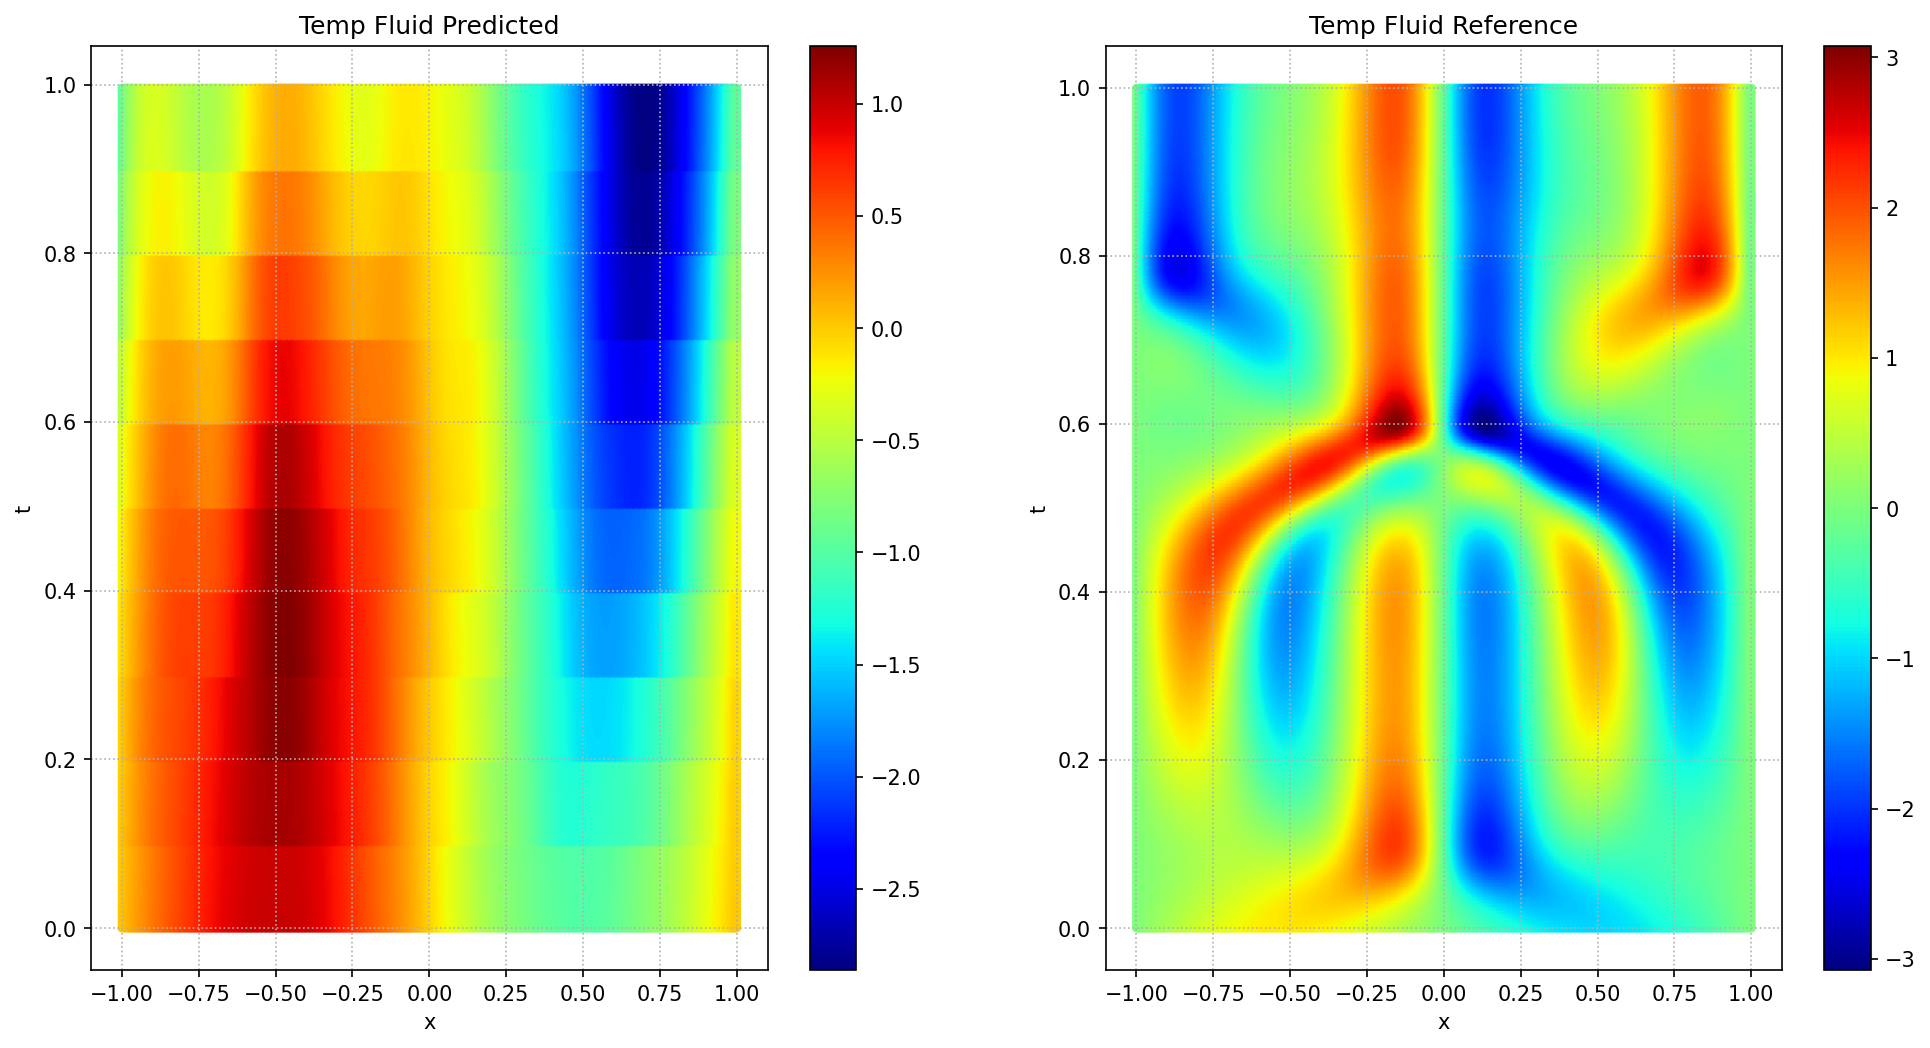

In [11]:
# Reference Solutions
import torch
import matplotlib.pyplot as plt
import jax.numpy as jnp
import scipy.io
import numpy
data = scipy.io.loadmat('ks_simple.mat')
outputs_ref = data['usol']
t = data['t'][0][:250]
t_copy = data['t'][0]
x = data['x'][0]
tt, xx = np.meshgrid(t, x)
tt_copy, xx_copy = np.meshgrid(t_copy, x)
inputs_ref = np.vstack((np.ravel(tt), np.ravel(xx))).T
inputs_ref_copy = np.vstack((np.ravel(tt_copy), np.ravel(xx_copy))).T

print(len(t[25:]))
print(len(x))
print(inputs_ref[:,0][25:].shape)
print(inputs_ref[:,1].shape)
# Define Plotting Function
def plotting_compare():
    """
    inputs_pinn = torch.from_numpy(inputs_ref).to(torch.float32).to(device)
    outputs_pinn = model.approximate_solution_flame(inputs_pinn).cpu().reshape(512, 251)
    difference = torch.abs(outputs_pinn-torch.from_numpy(outputs_ref).to(torch.float32))
    """
    #vmin = outputs_ref.min()
    #vmax = outputs_ref.max()
    #yoink = torch.from_numpy(u_pred_list[0].numpy())
    yoink = numpy.asarray(u_pred_list[0]).copy()
    yoink = torch.from_numpy(yoink)
    print(type(yoink))
    for i in range(1,N):
      boink = numpy.asarray(u_pred_list[i]).copy()
      boink = torch.from_numpy(boink)
      yoink = torch.cat((yoink, boink), dim=1)

    print(type(yoink))
    print(yoink.shape)
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)

    im1 = axs[0].scatter(inputs_ref[:,1], inputs_ref[:,0], c=yoink, cmap="jet", s=10 )#vmin=vmin, vmax=vmax)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("t")
    plt.colorbar(im1, ax=axs[0])
    axs[0].grid(True, which="both", ls=":")
    axs[0].set_title("Temp Fluid Predicted")

    im2 = axs[1].scatter(inputs_ref_copy[:, 1], inputs_ref_copy[:, 0], c=outputs_ref, cmap="jet", s=10 )#vmin=vmin, vmax=vmax)
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("t")
    plt.colorbar(im2, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")
    axs[1].set_title("Temp Fluid Reference")

    plt.show()

    """
    fig2, ax3 = plt.subplots(figsize=(8, 6), dpi=150)
    im3 = ax3.scatter(inputs_ref[:, 1], inputs_ref[:, 0], c=difference.detach(), cmap="jet", s=10)
    ax3.set_xlabel("x")
    ax3.set_ylabel("t")
    plt.colorbar(im3, ax=ax3)
    ax3.grid(True, which="both", ls=":")

    ax3.set_title("Difference Plot")

    plt.show()
    """


plotting_compare()